In [1]:
import numpy as np
import awkward
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')
import numpy as np
import scipy.optimize as opt
import sys, os, random, gzip
import tensorflow as tf
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
import pandas as pd
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
#     try:
#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#         tf.config.experimental.set_virtual_device_configuration(
#         gpus[0],
#         [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=80000)])
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#     except RuntimeError as e:
#     # Visible devices must be set before GPUs have been initialized
#         print(e)

Using TensorFlow backend.


In [2]:
##========================================================data by pythia
_e,_pt,_eta,_phi,_logpt,_loge=0,1,2,3,4,5
def deltaPhi(phi1,phi2):
    x = phi1-phi2
    while x>= np.pi: x -= np.pi*2.
    while x< -np.pi: x += np.pi*2.
    return x

def deltaR(eta1,phi1,eta2,phi2):
    return (deltaPhi(phi1,phi2)**2+(eta1-eta2)**2)**0.5

def find_main_axis(clist):
    def fcn(p):
        dir_x,dir_y = np.cos(p[0]),np.sin(p[0])
        v = clist[(clist[:,_eta]**2+clist[:,_phi]**2)**0.5>1E-5]
        cosang = np.abs(dir_x*v[:,_eta]+dir_y*v[:,_phi])/(v[:,_eta]**2+v[:,_phi]**2)**0.5
        proj = (v[:,_pt]*cosang).sum()
        return -proj
    r = opt.minimize(fcn,[0.])
    if r.success: return r.x[0]
    else: return None
def parse_jet_data(fin):
    
    
#     if '<jet_data>' not in fin.readline().decode():
#         print(">>> ERROR: invalid input", flush=True)
#         sys.exit(0)
    
    data = {}
#     features_list = {}
    fin.readline().decode().split()
    buf = fin.readline().decode().split() # jet kinematics
    data['e'] = float(buf[0])
    data['pt'] = float(buf[1])
    data['eta'] = float(buf[2])
    data['phi'] = float(buf[3])
    data['nconstituents'] = int(buf[4])
    fin.readline().decode().split()
    clist, mask, features, points = [],np.zeros((100,1)), np.zeros((100,5)), np.zeros((100,2)) # prepare constituents list
    if (data['nconstituents']<=100):
        for i in range(data['nconstituents']):  ##particlenet need to be 100
            #         _pt,_eta,_phi=1,2,3 #myfile use pt in index 1, eta->2,phi->3
            var = [float(s) for s in fin.readline().decode().split()] # index, type(0:gen/1:track/2:Ecal/3:Hcal), pid, charge, pt, eta, phi, vx, vy, vz
            var_logpt = np.log(var[_pt])
            var_loge = np.log(var[_e])
            var[_eta] = var[_eta]-data['eta']
            var[_phi] = deltaPhi(var[_phi],data['phi'])
            mask[i]=np.array([var_logpt])
            features[i]=np.array([var_logpt,var_loge,var[_eta],var[_phi], var[_pt]/data['pt']] ) #last one is my argue
            points[i]=np.array([var[_eta],var[_phi] ])#, var[_pt]/data['pt']])
    else:
        for i in range(data['nconstituents']):
            fin.readline().decode().split()
       

#     clist = np.array(clist)
#     features_list['mask']=np.array(mask)
#     features_list['points']=np.array(points)
#     features_list['features']=np.array(features)
#     dir = find_main_axis(clist) ##rotation
#     if dir!=None:
#         dir = -dir # rotation everything to x-axis
#         clist[:,_eta], clist[:,_phi] = np.cos(dir)*clist[:,_eta]-np.sin(dir)*clist[:,_phi], np.sin(dir)*clist[:,_eta]+np.cos(dir)*clist[:,_phi]

    
    return mask.tolist(), features.tolist(), points.tolist()
def prepare(n,fin,skip=0):
    fin=gzip.open(fin)
    features_list = {}
    mask, features, points = [],[],[]
    for i in range(n):
        a, b, c = parse_jet_data(fin)
        if(i>skip):    
            mask.append(a)
            features.append(b)
            points.append(c)
    features_list['mask']=mask
    features_list['points']=points
    features_list['features']=features
    return features_list
    
def separatedata(features_list,y,rateval,ratetest):
    features_train, features_test, features_val={},{},{}
    from sklearn.model_selection import train_test_split
    mask = features_list["mask"]
    features = features_list["features"]
    points = features_list["points"]
    X_ind = [i for i in range(len(y))]
    X_train, X_ind, y_train, y_ind = train_test_split(X_ind, y, test_size=rateval+ratetest)
    N=int(len(X_ind)*rateval/(rateval+ratetest))
    X_val, X_test = X_ind[:N], X_ind[N:]
    y_val, y_test = y_ind[:N], y_ind[N:]
    features_train['mask']=np.array([mask[i] for i in X_train])
    features_train['features']=np.array([features[i] for i in X_train])
    features_train['points']=np.array([points[i] for i in X_train])
    
    features_test['mask']=np.array([mask[i] for i in X_test])
    features_test['features']=np.array([features[i] for i in X_test])
    features_test['points']=np.array([points[i] for i in X_test])
    
    features_val['mask']=np.array([mask[i] for i in X_val])
    features_val['features']=np.array([features[i] for i in X_val])
    features_val['points']=np.array([points[i] for i in X_val])
    
    return features_train, features_val, features_test,np.array(y_train), np.array(y_val), np.array(y_test) 
def merging(gg,qq):
    total={}
    total['mask']=gg["mask"]+qq["mask"]
    total['features']=gg["features"]+qq["features"]
    total['points']=gg['points']+qq['points']
    return total
def input_trans( X_test, y_test):
    features_test = {}
    
    features_test['mask']=np.array([i for i in X_test["mask"]])
    features_test['features']=np.array([i for i in X_test["features"]])
    features_test['points']=np.array([i for i in X_test["points"]])
    return features_test, np.array(y_test) 

In [ ]:
## load data
path = '/home/ja2006203966/event/Pythia/firstjet/'
eventg, eventq = path+'myevents'+'gg'+'__tot.txt.gz', path+'myevents'+'qq'+'__tot.txt.gz'
n=100000
gg = prepare(n,eventg)
qq = prepare(n,eventq)
y=[[0,1] for i in range(len(gg['mask']))]+[[1,0] for i in range(len(qq['mask']))] 
total = merging(gg,qq)
# del gg, qq, eventg, eventq
del gg, qq, eventg, eventq

X_train, X_val, X_test, y_train, y_val, y_test = separatedata(total,y,0.1,0.1)

In [13]:
## separate sample into 10 pieces
path = '/home/ja2006203966/event/Pythia/firstjet/'
eventg, eventq = path+'myevents'+'gg'+'__tot.txt.gz', path+'myevents'+'qq'+'__tot.txt.gz'
n=1000000
N=10 # num you want to split
for i in range(N):
    gg = prepare(int(n/N)*(i+1),eventg,skip=int(i*n/N))
    qq = prepare(int(n/N)*(i+1),eventq,skip=int(i*n/N))
    y=[[0,1] for i in range(len(gg['mask']))]+[[1,0] for i in range(len(qq['mask']))] ##?????????????????
    total = merging(gg,qq)
    del gg, qq
    X_train, X_val, X_test, y_train, y_val, y_test = separatedata(total,y,0.1,0.1)
    np.save("./X_train"+str(i),X_train)
    np.save("./X_val"+str(i),X_val)
    np.save("./X_test"+str(i),X_test) 
    np.save("./y_train"+str(i),y_train)
    np.save("./y_val"+str(i),y_val)
    np.save("./y_test"+str(i),y_test)
    

In [ ]:
def merging_np(gg,qq,gy,qy):
    total={} 
    total['mask']= np.array( gg["mask"].tolist()+qq["mask"].tolist() )
    total['features']= np.array( gg["features"].tolist()+qq["features"].tolist())
    total['points'] = np.array( gg['points'].tolist()+qq['points'].tolist()) 
    ty = np.array(gy.tolist() + qy.tolist()) 
    return total, ty 

In [9]:
## save test data and vaild data
N=10
for i in range(N):
    X_test = np.load("./X_test"+str(i)+".npy",allow_pickle=True)
    X_test = X_test.item()  
    y_test = np.load("./y_test"+str(i)+".npy",allow_pickle=True)
    if (i==0):
        test_X = X_test
        test_y = y_test
        continue
    test_X, test_y = merging_np(test_X, X_test, test_y, y_test )
X_test = test_X
y_test = test_y
np.save("./X_test",X_test) 
np.save("./y_test",y_test)

del test_X, test_y
    
    
N=10
for i in range(N):
    X_val = np.load("./X_val"+str(i)+".npy",allow_pickle=True)
    X_val = X_val.item()  
    y_val = np.load("./y_val"+str(i)+".npy",allow_pickle=True)
    if (i==0):
        test_X = X_val
        test_y = y_val
        continue
    test_X, test_y = merging_np(test_X, X_val, test_y, y_val )
X_test = test_X
y_test = test_y
np.save("./X_val",X_test) 
np.save("./y_val",y_test)

del test_X, test_y
         
    

In [2]:


import tensorflow as tf
from tensorflow import keras
# from my_particlenet import get_MCGCNN, get_particle_net
# from MCGCNN2 import get_MCGCNN, get_particle_net
# from MCGCNN3 import get_MCGCNN, get_particle_net
from tf_keras_model import get_particle_net, get_particle_net_lite

In [21]:
##self

# model_type = 'particle_net'
input_shapes={'points': (100, 2), 'features': (100, 5), 'mask': (100, 1)}
num_classes = 2
w =  -2 ## weights you can choose (it is added by myself, and I use the 5-th as the weight term)
## if you want to use ParticleNet please set w = 0 
# model = get_MCGCNN(num_classes, input_shapes, w=w, K=16)

model = get_particle_net(num_classes, input_shapes, w=w)

In [2]:
# Training parameters
batch_size = 200
epochs = 200

In [5]:
# def lr_schedule(epoch):
#     lr = 1e-3
#     if epoch > 10:
#         lr *= 0.1
#     elif epoch > 20:
#         lr *= 0.01
#     logging.info('Learning rate: %f'%lr)
#     return lr
def lr_schedule(epoch):
    lr = 2e-2
    n = 10
    if epoch > 10:
        lr *= 1/n
    if epoch > 20:
        lr *= 1/n
    if epoch > 30:
        lr *= 1/n
    if epoch > 40:
        lr *= 1/n
    if epoch > 50:
        lr *= 1/n
    if epoch > 60:
        lr *= 1/n
    if epoch > 70:
        lr *= 1/n
#     if epoch > 16:
#         lr *= 1/n
#     if epoch > 21:
#         lr *= 1/n
#     if epoch > 26:
#         lr *= 1/n
#     if epoch > 31:
#         lr *= 1/n
#     if epoch > 36:
#         lr *= 1/n
#     if epoch > 41:
#         lr *= 1/n
    logging.info('Learning rate: %f'%lr)
    return lr

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
# optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0))
model.summary()

Model: "MCGCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
features (InputLayer)           [(None, 100, 5)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF [(None, 100, 1, 5)]  0           features[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_7 (Tenso [(None, 100, 1, 5)]  0           features[0][0]                   
__________________________________________________________________________________________________
MCGCNN1_fts_bn (BatchNormalizat (None, 100, 1, 5)    20          tf_op_layer_ExpandDims[0][0]     
_____________________________________________________________________________________________

In [4]:
# model = tf.keras.models.load_model('./MCGCNN.h5')  
# model = tf.keras.models.load_model('./train/MCGCNN.h5')  

In [5]:
# Prepare model model saving directory.
import os
# model_type = "MCGCNN"
model_type = "ParticleNet"
save_dir = './model_checkpoints'
model_name = '%s_model.test.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

# lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)

progress_bar = keras.callbacks.ProgbarLogger()
csv_logger = keras.callbacks.CSVLogger('./myparticlenet_training_log.csv')
earlystop = tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=1e-4,
                            patience=10,
                            verbose=1,
                            mode='min', baseline=None, ## 'min' 
                            restore_best_weights=True)
# callbacks = [checkpoint, lr_scheduler, progress_bar]
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001)
# callbacks = [checkpoint, reduce_lr, csv_logger, progress_bar, earlystop ] ## [checkpoint, lr_scheduler, csv_logger, progress_bar, earlystop ]
callbacks = [checkpoint, csv_logger, progress_bar, earlystop ]
### Add checkpoints
##########################################################################################################
# check_list=[]
# checkpoint = tf.keras.callbacks.ModelCheckpoint (monitor='val_loss',
#                              filepath='./mymodel.h5',
#                              save_best_only=True,
#                              verbose=1)
# earlystop = tf.keras.callbacks.EarlyStopping(
#                             monitor='val_loss',
#                             min_delta=0,
#                             patience=50,
#                             verbose=1,
#                             mode='min', baseline=None,
#                             restore_best_weights=True)

# csv_logger = tf.keras.callbacks.CSVLogger('./training_log.csv')
# check_list.append(checkpoint)
# check_list.append(earlystop)
# check_list.append(csv_logger)
##########################################################################################################

In [3]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pickle

In [5]:
## train on small batches
path = '/home/ja2006203966/event/Pythia/firstjet/'
eventg, eventq = path+'myevents'+'gg'+'__tot.txt.gz', path+'myevents'+'qq'+'__tot.txt.gz'
X_val = np.load("./X_val.npy",allow_pickle=True)
X_val = X_val.item()
y_val = np.load("./y_val.npy",allow_pickle=True)
# n=1000000
valm = [99999,0]
earlystop_n = 2
LOSS0 = 0
N=10 # num you want to split
for j in range(epochs):
    if (j-valm[1]>earlystop_n):
        break
    for i in range(N):
        print("epochs= " ,j, "/",epochs, "\tbatch= ", i, "/",N)
        X_train = np.load("./X_train"+str(i)+".npy",allow_pickle=True)
        X_train = X_train.item()
#         X_val = np.load("./X_val"+str(i)+".npy",allow_pickle=True)
#         X_val = X_val.item()
#         X_test = np.load("./X_test"+str(i)+".npy",allow_pickle=True)
#         X_test = X_test.item() 
        
        y_train = np.load("./y_train"+str(i)+".npy",allow_pickle=True)
#         y_val = np.load("./y_val"+str(i)+".npy",allow_pickle=True)
#         y_test = np.load("./y_test"+str(i)+".npy",allow_pickle=True)
        model.fit(X_train, y_train,batch_size=batch_size,epochs=1, validation_data=(X_val, y_val), shuffle=True , callbacks=callbacks)
        val = model.evaluate(X_val,  y_val, verbose=2)
        LOSS1 = pd.read_csv('./myparticlenet_training_log.csv')
        LOSS1['epoch'][0] = j
        if (i==0)&(j==0):
            LOSS0 = LOSS1
            LOSS0.to_csv("./checkpoint.csv")
        else:
            LOSS0 = LOSS0.append(LOSS1, ignore_index=True)
            LOSS0.to_csv("./checkpoint.csv")
        del X_train, y_train
        if (round(val[0],4)<round(valm[0],4)):
            model.save('./MCGCNN.h5')
#             model.save('./ParticleNet.h5')
            valm[0] = val[0]
            valm[1] = j
            
        


epochs=  0 / 200 	batch=  0 / 10


NameError: name 'callbacks' is not defined

In [ ]:
# if your sameple is small
model.fit(X_train ,y_train,
          batch_size=batch_size
          epochs=epochs, # --- train only for 1 epoch here for demonstration ---
          validation_data=(X_val, y_val),
          shuffle=True ,
          callbacks=callbacks)
model.evaluate(X_test,  y_test, verbose=2)

In [9]:
a = model.evaluate(X_test,  y_test, verbose=2)
np.save("./loss_acc",a)
a


200000/1 - 165s - loss: 0.4024 - accuracy: 0.8231


[0.407078766746521, 0.82312]

In [9]:
np.save("./loss_acc",a)

In [ ]:
# model.save('./my_ParticleNet.h5')
model.save('./MCGCNN_f.h5')

In [ ]:
# model.save('./MCGCNN_f.h5')
model.save('./ParticleNet_f.h5')

In [5]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pickle

In [6]:
# model = tf.keras.models.load_model('./ParticleNet.h5')
# model = tf.keras.models.load_model('./MCGCNN.h5')
model = tf.keras.models.load_model('./train/MCGCNN_best.h5')  

The area under the curves are:
AUC:0.892826398


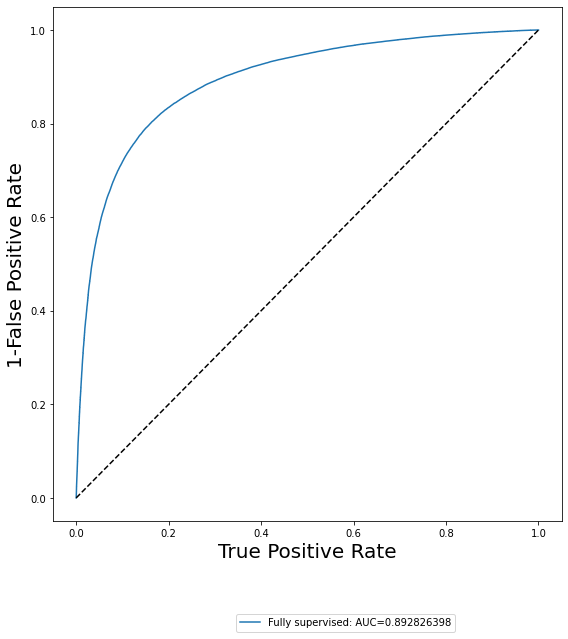

In [7]:
# y_test=[i[1] for i in testpojen_datay]
X_test = np.load("./X_test.npy",allow_pickle=True)
X_test = X_test.item()
y_test = np.load("./y_test.npy",allow_pickle=True)
y_score=model.predict(X_test)[:,0]
test=[i[1] for i in y_test]
fpr , tpr , thresholds = roc_curve ( test , y_score)
roc_auc = auc(tpr,fpr )
print("The area under the curves are:")
print("AUC:{0:.9f}".format(roc_auc))
# FalsePositiveFull, TruePositiveFull, ThresholdFull = metrics.roc_curve(y_test,Predictions)
plt.figure(figsize=(8,16))
plt.subplot(2,1,1)

plt.plot(tpr,fpr, label='Fully supervised: AUC={0:.9f}'.format(roc_auc))
plt.ylabel('1-False Positive Rate',fontsize=20)
plt.xlabel('True Positive Rate',fontsize=20)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("./Myneighnorhood_Particlenet_roc.png")
np.save("./myfpr",fpr)
np.save("./mytpr",tpr)
#plt.close()
 
# plt.subplot(2,1,2) 
# LOSS = pd.read_csv('./training_log.csv')
# plt.plot(LOSS["loss"], label='loss',c='blue')
# plt.plot(LOSS["val_loss"], label='val_loss',c='red')
# plt.ylabel('loss',fontsize=20)
# plt.xlabel('epoch',fontsize=20)
# plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
# plt.tight_layout()

#plt.savefig("./plot_3.png")
#plt.close()
plt.show()

In [27]:
# LOSS1 = pd.read_csv('./myparticlenet_training_log.csv')
LOSS1 = pd.read_csv('./plot/2/myparticlenet_training_log.csv')

In [20]:
label=[]
for i in LOSS2:
    label.append(i)

In [13]:
LOSS1[label[1]] = LOSS1[label[1]].tolist()

In [28]:
LOSS1 = LOSS1.append(LOSS1, ignore_index=True)

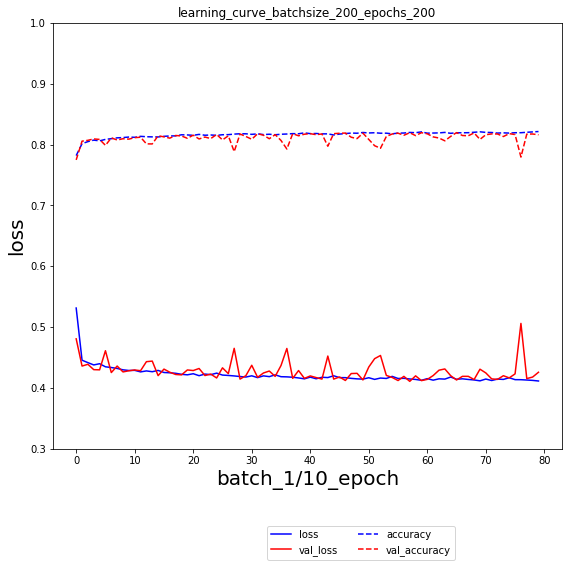

In [8]:
plt.figure(figsize=(8,8))
# LOSS = pd.read_csv('./myparticlenet_training_log.csv')
# LOSS = pd.read_csv("./checkpoint.csv")
LOSS = pd.read_csv("./train/checkpoint.csv")
plt.title("learning_curve_batchsize_"+str(batch_size)+"_epochs_"+str(epochs))
plt.plot(LOSS["loss"], label='loss',c='blue')
plt.plot(LOSS["val_loss"], label='val_loss',c='red')
plt.plot(LOSS["accuracy"], linestyle='--', label='accuracy',c='blue')
plt.plot(LOSS["val_accuracy"], linestyle='--', label='val_accuracy',c='red')
plt.ylim([0.3,1])
plt.ylabel('loss',fontsize=20)
plt.xlabel('batch_1/10_epoch',fontsize=20)
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("./myloss.png")
#plt.savefig("./plot_3.png")
#plt.close()
plt.show()

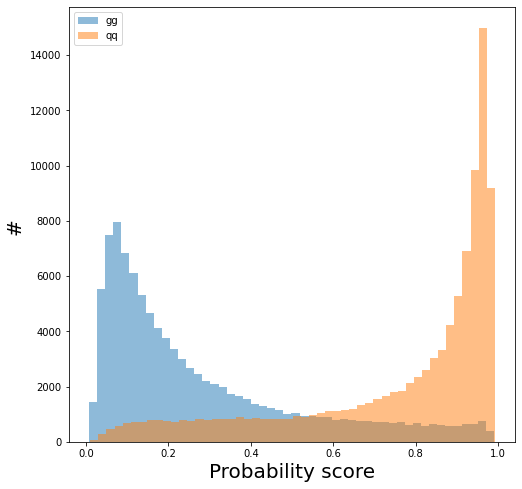

In [9]:
plt.figure(figsize=(8,8))
x=[y_score[i] for i in range(len(y_score)) if y_test[i][1]!=0 ]
y=[y_score[i] for i in range(len(y_score)) if y_test[i][1]!=1 ]
plt.hist(x, label='gg',bins=50,alpha=0.5)
plt.hist(y, label='qq',bins=50,alpha=0.5)
plt.ylabel('# ',fontsize=20)
plt.xlabel('Probability score',fontsize=20)
plt.legend()
plt.savefig("./Myneighnorhood_Particlenet_Prob.png")
np.save("./mygg",x)
np.save("./myqq",y)

In [18]:
y[0]

49123204.0